# Maximum Temperature Prediction

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

## Reading the files

In [2]:
weather = pd.read_csv("daily_weather.csv")
# Training data, choose a name ["NY CITY CENTRAL PARK, NY US", "AUSTIN BERGSTROM INTERNATIONAL AIRPORT, TX US","MIAMI INTERNATIONAL AIRPORT, FL US", "CHICAGO MIDWAY AIRPORT, IL US"]
train_df = weather.loc[weather['NAME'] == "NY CITY CENTRAL PARK, NY US"]
# Testing data, choose a file ["weather_nyc.csv", "weather_aus.csv", "weather_mia.csv", "weather_chi.csv"]
test_df = pd.read_csv("weather_nyc.csv")
# Combine test and training data for preprocessing
weather_df = pd.concat([train_df, test_df], axis=0)
print(weather_df.head())

           STATION                         NAME        DATE  PRCP  SNWD  TMAX  \
19104  USW00094728  NY CITY CENTRAL PARK, NY US  1998-01-01   0.0   NaN  29.0   
19105  USW00094728  NY CITY CENTRAL PARK, NY US  1998-01-02   0.0   NaN  51.0   
19106  USW00094728  NY CITY CENTRAL PARK, NY US  1998-01-03   0.0   NaN  60.0   
19107  USW00094728  NY CITY CENTRAL PARK, NY US  1998-01-04   0.0   NaN  62.0   
19108  USW00094728  NY CITY CENTRAL PARK, NY US  1998-01-05   0.0   NaN  50.0   

       TMIN  
19104  14.0  
19105  29.0  
19106  46.0  
19107  44.0  
19108  42.0  


## Pre-processing

Check for missing values.

In [3]:
print(weather_df.isnull().mean())

STATION    0.002193
NAME       0.002193
DATE       0.000000
PRCP       0.000209
SNWD       0.049488
TMAX       0.000104
TMIN       0.000104
dtype: float64


Remove and fill missing values.

In [4]:
# Remove any columns which have less than 60% non-missing values
weather_df = weather_df.dropna(thresh=train_df.shape[0]*0.6, axis=1)
# Fill missing values with prev value and if it is still empty fill with zero
weather_df = weather_df.replace('', np.NaN)
weather_df = weather_df.ffill()
weather_df = weather_df.fillna(0)
print(weather_df.isnull().mean())

STATION    0.0
NAME       0.0
DATE       0.0
PRCP       0.0
SNWD       0.0
TMAX       0.0
TMIN       0.0
dtype: float64


Normalize the data.

In [5]:
# Choose the features for the model
features = weather_df[['TMAX', 'TMIN', 'PRCP', 'SNWD']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)

Create labels, and divide data into training and testing sets.

In [6]:
# Create sequences and labels
seq_length = 7
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predicting only maximum temperature
    return np.array(X), np.array(y)

# Divide data into training and testing data
X_train, y_train = create_sequences(scaled_features[:len(train_df)], seq_length)
X_test, y_test = create_sequences(scaled_features[len(train_df):], seq_length)
print(X_test)
print(y_test)

[[[0.41021319 0.42811059 0.14614256 0.        ]
  [0.57241099 0.51811059 0.         0.        ]
  [0.4923011  0.46728706 0.         0.        ]
  [0.36570769 0.46834588 0.11077711 0.        ]
  [0.40131209 0.47469882 0.16174498 0.        ]
  [0.45372969 0.50646353 0.02392369 0.        ]
  [0.45372969 0.40164    0.         0.        ]]

 [[0.57241099 0.51811059 0.         0.        ]
  [0.4923011  0.46728706 0.         0.        ]
  [0.36570769 0.46834588 0.11077711 0.        ]
  [0.40131209 0.47469882 0.16174498 0.        ]
  [0.45372969 0.50646353 0.02392369 0.        ]
  [0.45372969 0.40164    0.         0.        ]
  [0.35680659 0.46199294 0.1612249  0.        ]]

 [[0.4923011  0.46728706 0.         0.        ]
  [0.36570769 0.46834588 0.11077711 0.        ]
  [0.40131209 0.47469882 0.16174498 0.        ]
  [0.45372969 0.50646353 0.02392369 0.        ]
  [0.45372969 0.40164    0.         0.        ]
  [0.35680659 0.46199294 0.1612249  0.        ]
  [0.41812527 0.43234588 0.10089557 

## Model

LSTM model using Keras.

In [7]:
model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(seq_length, X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=32, return_sequences=True),
    Dropout(0.2),
    LSTM(units=32),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             17664     
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             12416     
                                                                 
 dropout_1 (Dropout)         (None, 7, 32)             0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

Train the model.

In [8]:
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

Epoch 1/50
135/135 [==============================] - 11s 38ms/step - loss: 0.0361 - val_loss: 0.0092
Epoch 2/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0143 - val_loss: 0.0089
Epoch 3/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0138 - val_loss: 0.0089
Epoch 4/50
135/135 [==============================] - 3s 19ms/step - loss: 0.0131 - val_loss: 0.0087
Epoch 5/50
135/135 [==============================] - 3s 24ms/step - loss: 0.0128 - val_loss: 0.0086
Epoch 6/50
135/135 [==============================] - 3s 22ms/step - loss: 0.0123 - val_loss: 0.0084
Epoch 7/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0118 - val_loss: 0.0082
Epoch 8/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0112 - val_loss: 0.0081
Epoch 9/50
135/135 [==============================] - 3s 20ms/step - loss: 0.0112 - val_loss: 0.0082
Epoch 10/50
135/135 [==============================] - 4s 28ms/step - loss: 0.0105 - val_l

## Model Evaluation

In [9]:
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

predictions = model.predict(X_test)
# Denormalize the predictions and actual values
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((len(predictions), 3))), axis=1))[:, 0]
actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), 3))), axis=1))[:, 0]
print(predictions)

1/1 [==============================] - 0s 31ms/step - loss: 0.0082
Test Loss: 0.008237254805862904
1/1 [==============================] - 1s 1s/step
[49.40334445 48.99273238 47.68536121 47.71420345 56.96470055 53.33320075
 62.072321   64.4544487  54.59889102 61.04262996 48.64912054 48.93795788
 51.56686777 40.31913975]


Graph of predictions vs actual.

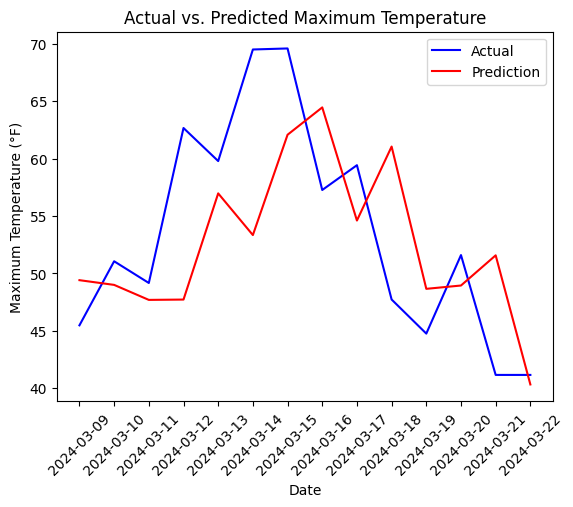

In [10]:
plt.plot(test_df['DATE'][seq_length:], actual, label='Actual', color='blue')
plt.plot(test_df['DATE'][seq_length:], predictions, label='Prediction', color='red')
plt.title('Actual vs. Predicted Maximum Temperature')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (°F)')
plt.xticks(rotation=45)
plt.legend()
plt.show()